<a href="https://colab.research.google.com/github/RachelRamirez/misclassification_matrix/blob/main/30_Runs_of_Baseline_40D_with_SGD_LR_0point1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# How to change the local time in Google Colab
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/US/Eastern /etc/localtime
!date

#If this doesn't show the local time correctly, then you need to restart.
import time
time.localtime(time.time())

Mon 01 May 2023 10:23:46 PM EDT


time.struct_time(tm_year=2023, tm_mon=5, tm_mday=2, tm_hour=2, tm_min=23, tm_sec=46, tm_wday=1, tm_yday=122, tm_isdst=0)

We'll start by writing a `.py` file which we'll import.

In [19]:
# import ImportLibraries_DefineFunctions
import requests
url = 'https://raw.githubusercontent.com/RachelRamirez/misclassification_matrix/main/ImportLibraries_DefineFunctions.py'
r = requests.get(url)


# make sure your filename is the same as how you want to import 
with open('ImportLibraries_DefineFunctions.py', 'w') as f:
    f.write(r.text)

# now we can import


In [ ]:
# import ImportLibraries_DefineFunctions   #This didn't work for some reason so I do execfile() instead and that works

In [20]:
# #@title
# # Bring the file into the local Python environment.
execfile('ImportLibraries_DefineFunctions.py')

# Call the function defined in the file.
# f()
time.localtime(time.time())

TF version:  2.12.0
Keras version:  2.12.0
Finished Loading Libraries
60000 train samples
7500 validation samples
2500 test samples
Train [0.09871667 0.11236667 0.0993     0.10218333 0.09736667 0.09035
 0.09863333 0.10441667 0.09751666 0.09915   ]
Train # of 9s 5949.0
Train # of 4s 5842.0
Val [0.09586667 0.1132     0.10453334 0.10066666 0.09986667 0.09013333
 0.09413333 0.1016     0.09746667 0.10253333]
Val # of 9s 769.0
Val # of 4s 749.0
Test [0.1044 0.1144 0.0992 0.102  0.0932 0.0864 0.1008 0.1064 0.0972 0.096 ]
Test  # of 9s 240.0
Test  # of 4s 233.0


time.struct_time(tm_year=2023, tm_mon=5, tm_mday=2, tm_hour=2, tm_min=23, tm_sec=30, tm_wday=1, tm_yday=122, tm_isdst=0)

In [ ]:
#@title
# Bring the file into the local Python environment.
execfile('ImportLibraries_DefineFunctions.py')

# Call the function defined in the file.
# f()
time.localtime(time.time())


In [ ]:
#@title
# #As of 4/18 I am changing this code to save weights initially after five epochs using lambdavalue=1 initially

# rms = RMSprop()  #https://keras.io/api/optimizers/rmsprop/ #default learning_rate=0.001
sgd = SGD(learning_rate=0.1)

patience = 0


# SET THE IITIAL LAMBDA VALUE! 
cost_matrix = np.ones((10,10))
lambda_val = 1

Truth=9
Predicted=4
cost_matrix[Truth, Predicted] = lambda_val


# # Define the per-epoch callback.
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix, )
# cr_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_classification_report, )
# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights = True)





# ## Examples from TDS
# from tensorflow.keras.callbacks import LambdaCallback
# epoch_callback = LambdaCallback(
#     on_epoch_begin=lambda epoch,logs: print('Starting Epoch {}!'.format(epoch+1))
# )
# batch_loss_callback = LambdaCallback(
#     on_batch_end=lambda batch,logs: print('\n After batch {}, the loss is {:7.2f}.'.format(batch, logs['loss']))
# )
# train_finish_callback = LambdaCallback(
#     on_train_end=lambda logs: print('Training finished!')
# )

# # Lambda function using if else & else if
# min = lambda a, b, c : f"{a} is smaller" if(a < b & b < c) \
#      else f"{b} is smaller"  if (b < c) else f"{c} is smaller" 
# print(min(40, 30, 10))

epoch_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end = lambda epoch,logs: 
                                                   print(' Epoch {} modulus 5 is {}!'.format(epoch+1, (epoch+1)%5))  )

# cr_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end= lambda epoch, logs:
# #                                                log_classification_report(epoch, logs) if(epoch+1)%5==0 else print(" ") )
#                                               #  return_cr if(epoch+1)%5==0 else print(" ") )


f1_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_f1_score)


model = create_model()

# save the model weights
model.save_weights('initial_0epochs.h5')



model.compile(loss=WeightedCategoricalCrossentropy(cost_matrix), optimizer=sgd,  metrics='categorical_accuracy',)

# model_history = model.fit(X_train, Y_train,  batch_size=batch_size, epochs=10, verbose=2,
#         validation_data=(X_val, Y_val), shuffle=True, use_multiprocessing=True, callbacks = [ cm_callback, f1_callback])

# model.save_weights('initial_10epochs.h5')

# model.save_weights('initial_10epochs.h5')
# model.save_weights('baseline_for_100epochs.h5')

# save the model weights
# model.save_weights('initial_150epochs.h5')

 
# cr = return_cr(model)
!date


The code below to generate variations of the model training / validation results after training with a cost matrix 30 times did not produce any variability.   Therefore I want to shuffle the training/validation deck randomly between training sessions to see if that helps introduce some randomness.  

#### The Training Runs - Commented out to ensure not run again when the notebook is saved with output

This takes hours to run for about 40 replications so usually after running, I save the out put to GitHub for easy lookup later

In [5]:
#@title
from google.colab import files

## -----------------------------------------------------------------------------------------------------
## Now we need to load the weights of the model, and continue training with a different cost matrix
## ------------------------------------------------------------------------------------------------------
# load the model weights
# model.load_weights('initial_5epochs.h5') 

df = pd.DataFrame()
cost_matrix = np.ones((10,10))

model_history_all = []
cm_all            = []

# cost_list = [10, 100, 1000, 1] # Each one takes about 2 minutes 5*4*2=40 minutes for 5 costs/4 reps -- actually all took 40 reps took almost  1.5 hours
cost_list = [1] # Each one takes about 2 minutes 5*4*2=40 minutes for 5 costs/4 reps -- actually all took 40 reps took almost  1.5 hours
reps = 30

for k in cost_list:
  for i in range(reps):
    print("starting rep ", i, " for ", k , "-cost.")

    cost_matrix[9,4] = k
    model = create_model()

    # model.load_weights('initial_10epochs.h5')

    #I may need to re-initiate the optimizer to have a smaller learning rate
    model.compile(loss=WeightedCategoricalCrossentropy(cost_matrix), optimizer=sgd,  metrics='categorical_accuracy',)
    
    nb_epoch = 110
    # patience = 20

    # es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights = True)

    X_train_shuffled = shuffle(X_train, random_state=42+i)
    Y_train_shuffled = shuffle(Y_train, random_state=42+i)
 

    history = model.fit(X_train_shuffled, Y_train_shuffled,          batch_size=batch_size, epochs=nb_epoch, verbose=0,
            validation_data=(X_val, Y_val), shuffle=True, use_multiprocessing=True, callbacks = [ cm_callback, f1_callback, epoch_callback])

    cm3 = return_cm(model)

    del(history.model)
    model_history_all.append(history)
    cm_all.append(cm3)
    ## Now I need to plot all of the "model_history_all"
 
  
    df = pd.concat([df, pd.DataFrame({"cost": k, "rep": i,
                                      "model_history": [history],
                                      "cm": [cm3]]
                                      })] , 
                   ignore_index=True )

    import pickle

    # save the variable to a pickle file
    with open('baseline_models_lr0point1.pkl', 'wb') as f:
        pickle.dump(model_history_all, f)

    files.download('baseline_models_lr0point1.pkl')

    with open('baseline_cms_lr0point1.pkl', 'wb') as f:
        pickle.dump(cm_all, f)

    files.download('baseline_cms_lr0point1.pkl')
    !date

    #Trying to Work Smarter and Save as Dataframe with Rep Cost History and CM
    with open('df_lr0point1.pkl', 'wb') as f:
        pickle.dump(df, f)

    df_string = "df_lr0point1_K" + str(k) + "_R" str(rep) + ".pkl" 
    files.download(df_string)




  # print(model_history_all) #18 items into _ is taking 1 hours and 3 minutes!  perhaps im not usng the right settings - i have no-accelerator on google colab
  print(df_string, " is final dataframe file")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

starting rep  19  for  1 -cost.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

starting rep  20  for  1 -cost.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

starting rep  21  for  1 -cost.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

starting rep  22  for  1 -cost.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

starting rep  23  for  1 -cost.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

starting rep  24  for  1 -cost.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

starting rep  25  for  1 -cost.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

starting rep  26  for  1 -cost.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

starting rep  27  for  1 -cost.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

starting rep  28  for  1 -cost.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

starting rep  29  for  1 -cost.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
    # # save the variable to a pickle file
    # with open('baseline_models_lr0point1.pkl', 'wb') as f:
    #     pickle.dump(model_history_all, f)

    # files.download('baseline_models_lr0point1.pkl')

    # with open('baseline_cms_lr0point1.pkl', 'wb') as f:
    #     pickle.dump(cm_all, f)

    # files.download('baseline_cms_lr0point1.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Download the multiple runs and reps of Model History from training with different lambda values


Also commented out because once everything is ran and saved, I don't want to accidentally save additional files

#### Load Model History Variables from Pickle Files - must have weighted-categorical-accuracy defined

In [12]:
#Upload and save the history to variable 
import pickle

# #load the pickle file
with open('baseline_models_lr0point1.pkl', 'rb') as handle:
    model_history_all = pickle.load(handle)

# import keras
# keras.models.load_model('initial_10_secondphase_lambda_history.pkl')
#use the loaded variable
print(model_history_all)

# #load the pickle file
with open('baseline_cms_lr0point1.pkl', 'rb') as handle:
    cm_all = pickle.load(handle)

# use the loaded variable
print(cm_all)

df_string

# #load the pickle file
with open(df_string, 'rb') as handle:
    df = pickle.load(handle)

# use the loaded variable
print(df)
 

[<keras.callbacks.History object at 0x7f6a59960dc0>, <keras.callbacks.History object at 0x7f6a601c45e0>, <keras.callbacks.History object at 0x7f6a71518220>, <keras.callbacks.History object at 0x7f6a786411e0>, <keras.callbacks.History object at 0x7f6a60170e80>, <keras.callbacks.History object at 0x7f6a5a70ecb0>, <keras.callbacks.History object at 0x7f6a5a27fa00>, <keras.callbacks.History object at 0x7f6a71484a30>, <keras.callbacks.History object at 0x7f6a599e1000>, <keras.callbacks.History object at 0x7f6a71306fe0>, <keras.callbacks.History object at 0x7f6a59b68280>, <keras.callbacks.History object at 0x7f6a5a377dc0>, <keras.callbacks.History object at 0x7f6a5af01300>, <keras.callbacks.History object at 0x7f6a59ca08b0>, <keras.callbacks.History object at 0x7f6a7167c7f0>, <keras.callbacks.History object at 0x7f6a60243f40>, <keras.callbacks.History object at 0x7f6a5a3b4bb0>, <keras.callbacks.History object at 0x7f6a59bc3d30>, <keras.callbacks.History object at 0x7f6a71948fd0>, <keras.call

In [13]:
# #I want to break out the model_history and cm_history into a dataframe to be referenced by Cost and Rep
# import pandas as pd
# df = pd.DataFrame()
# count=1


# #It'd be better if i could refer to the "cost"/lambda2 as a variable in the model_history, 
# # but i recreated it here
# # 
# # cost_list = [10, 100, 1000, 1] # Each one takes about 2 minutes 5*4*2=40 minutes for 5 costs/4 reps -- actually all took 40 reps took almost  1.5 hours

# cost_list = [ 1]

# for k in cost_list:

  
# #It'd be better if i could refer to the reps a variable in the model_history, 
# # but i recreated it here as the range(10) that was originally used

#   for i in range(30):
#     # print("k: ", k, "i: ", i)
#     df = pd.concat([df, pd.DataFrame({"cost": [k], "rep": [i],
#                                       "model_history": [model_history_all[count-1]],
#                                       # "cm": [cm_all[count-1]]
#                                       })] , 
#                    ignore_index=True )
#     count+=1    


# I create a dataframe with CSV but  don't save/download it 
df.to_csv('dataframe.csv',index=False)



Group of Lambda-Value: 1


<Figure size 2000x1000 with 0 Axes>

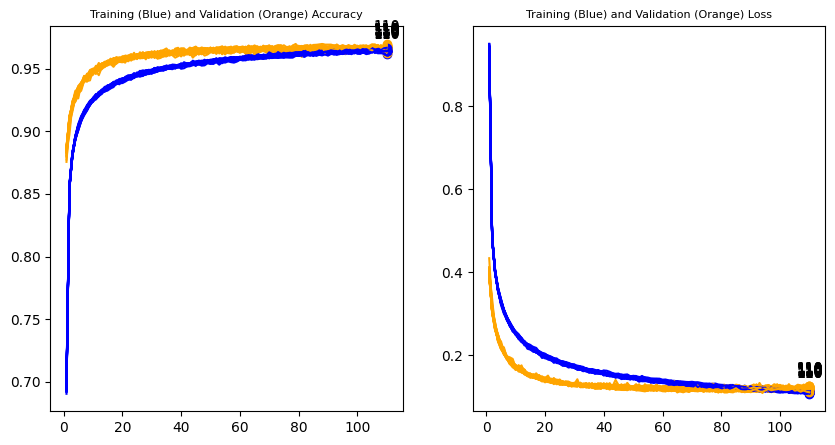

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import time
nb_epoch = 110
patience = 0
df.groupby("cost")

for x, group in df.groupby("cost"):
  fig = plt.figure(figsize=(20, 10)) 
  fig, ax = plt.subplots(1,2)
  print("Group of Lambda-Value:",   x)

  # group
  for item in group.model_history:
    plot_model_history_all(item)    
  plt.show()
  

In [15]:
df["model_history"][0].history.keys()


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', '9T_4P', '4T_9P', '0T_Acc', '1T_Acc', '2T_Acc', '3T_Acc', '4T_Acc', '5T_Acc', '6T_Acc', '7T_Acc', '8T_Acc', '9T_Acc', 'cm_per_epoch', 'f1_micro', 'f1_macro', 'f1_weighted', 'f1_notweighted'])

The plots  look very similar.  The loss values, even with shuffling, are nearly identical at least within 0.01 for the first three epochs of runs 1 and 2 (haven't checked all, but the plot makes it look like the runs are nearly identical)

In [16]:
df["model_history"][2].history["val_loss"][0] - df["model_history"][1].history["val_loss"][0]
df["model_history"][2].history["val_loss"][1] - df["model_history"][1].history["val_loss"][1]
df["model_history"][2].history["val_loss"][2] - df["model_history"][1].history["val_loss"][2]

0.008294641971588135

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


What is the highest misclassification?



0


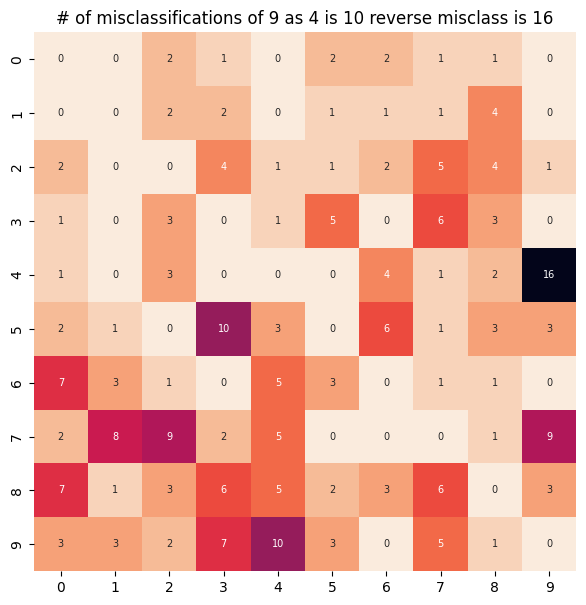

1


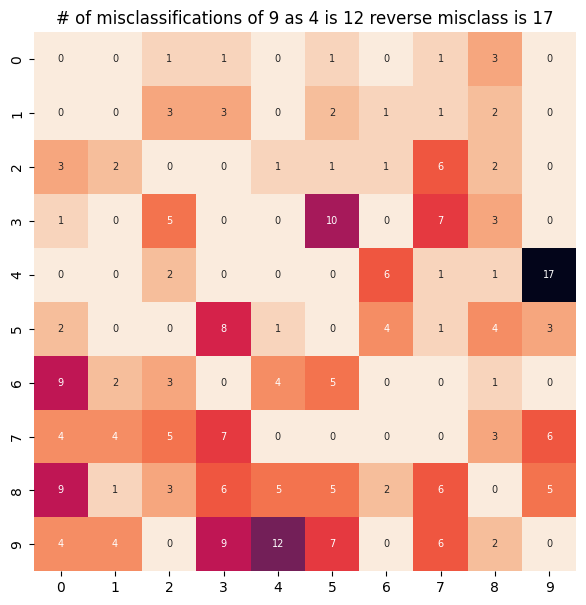

2


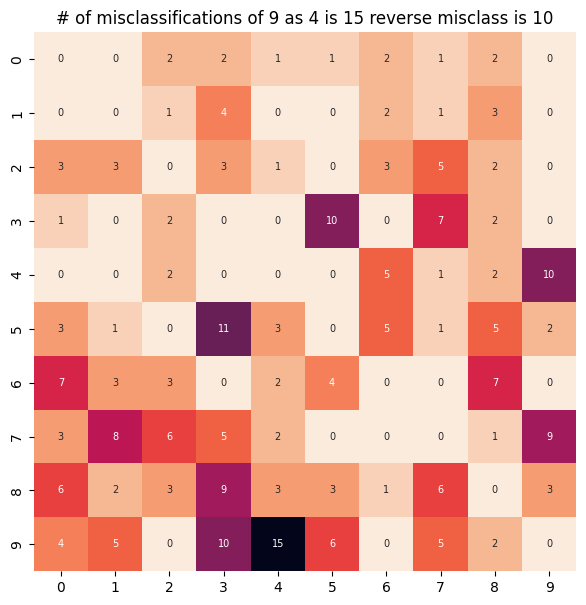

3


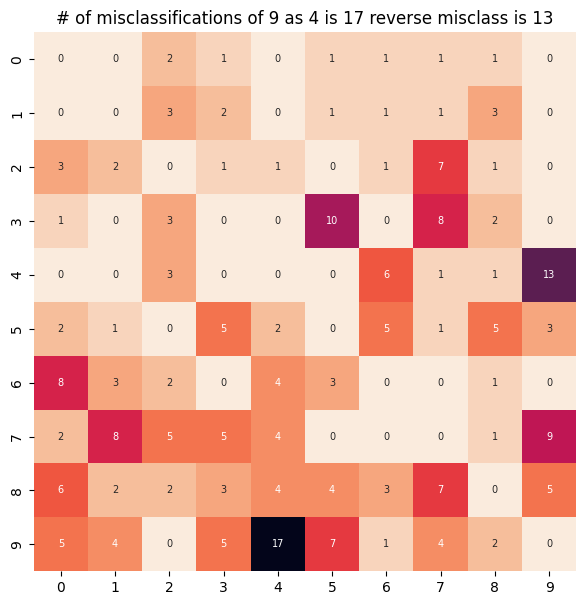

4


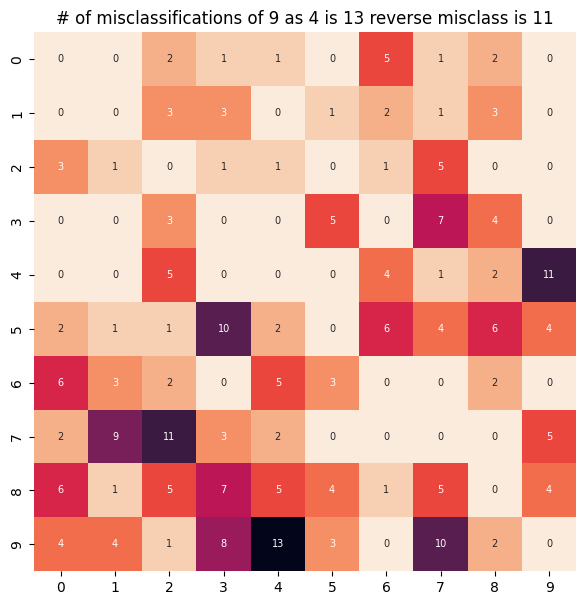

5


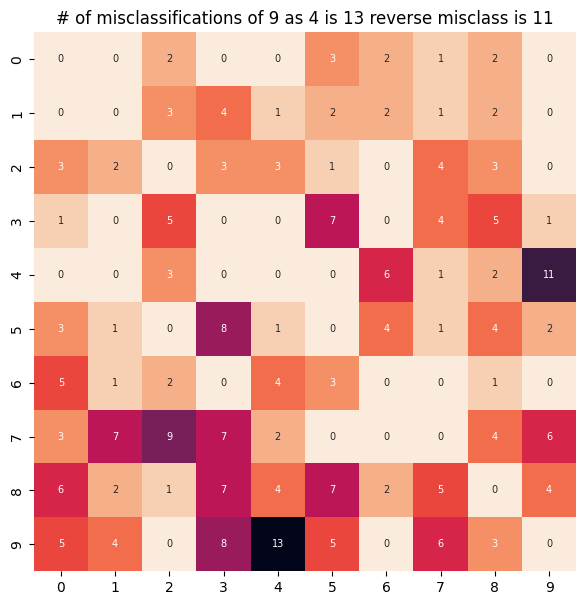

6


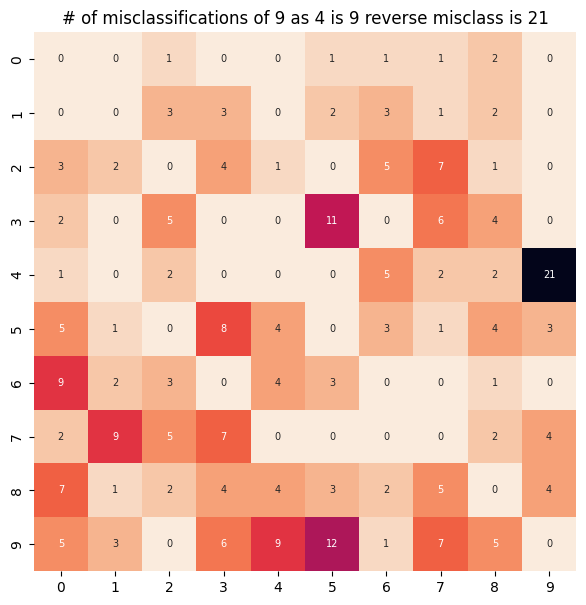

7


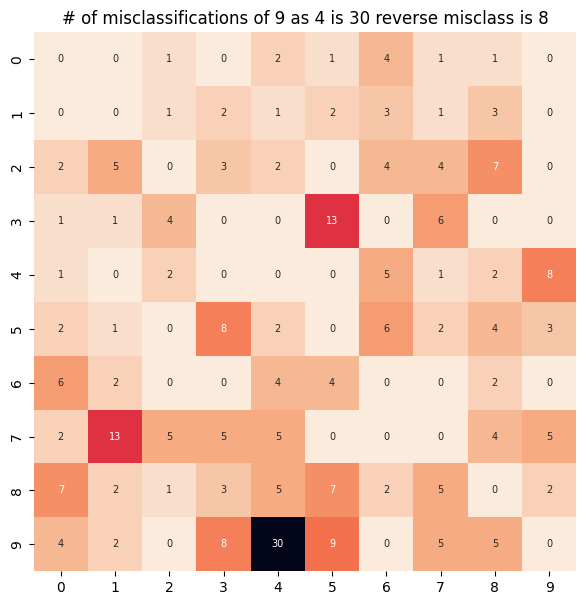

8


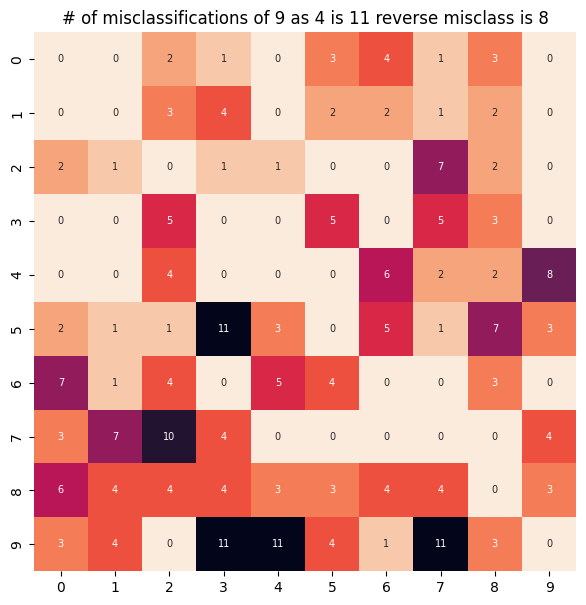

9


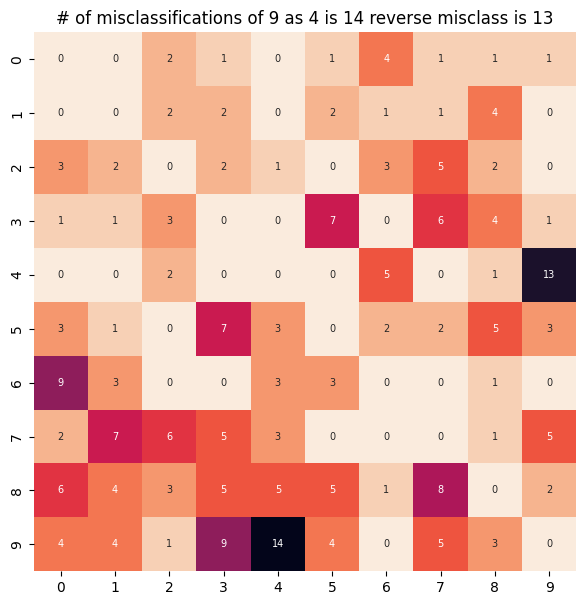

10


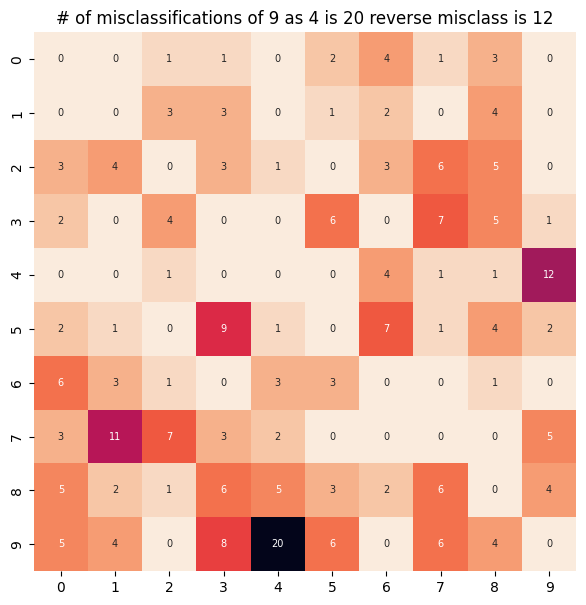

11


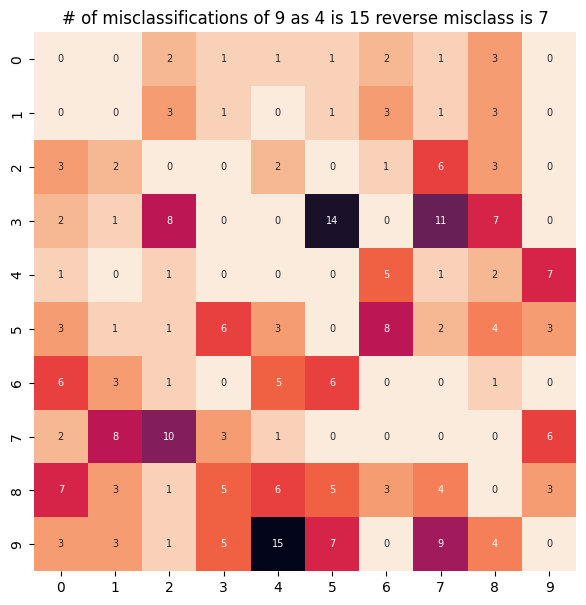

12


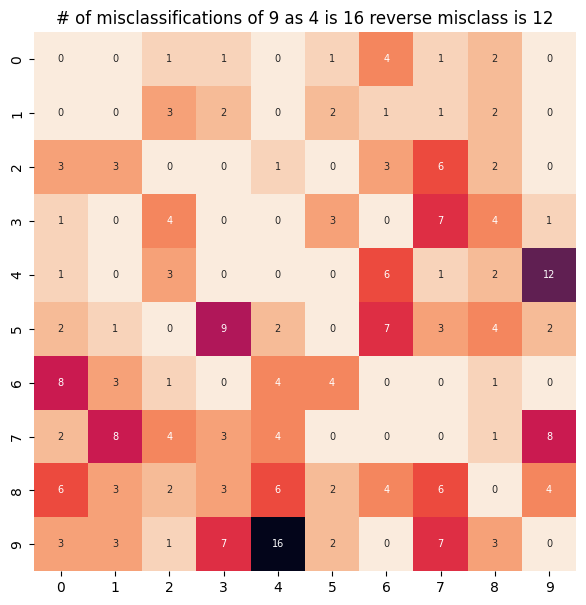

13


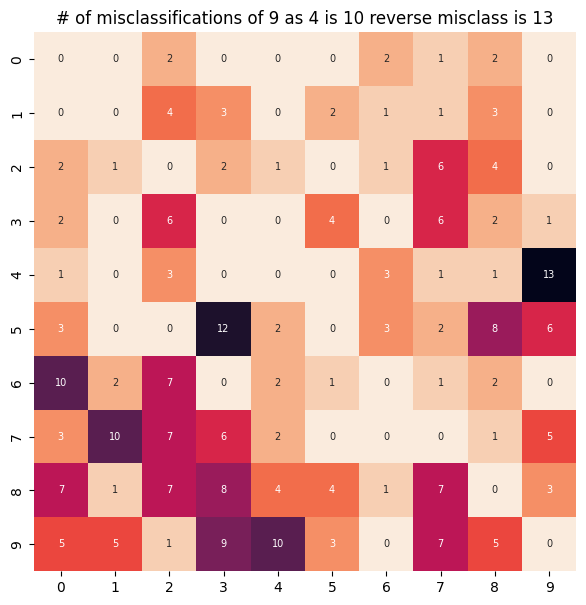

14


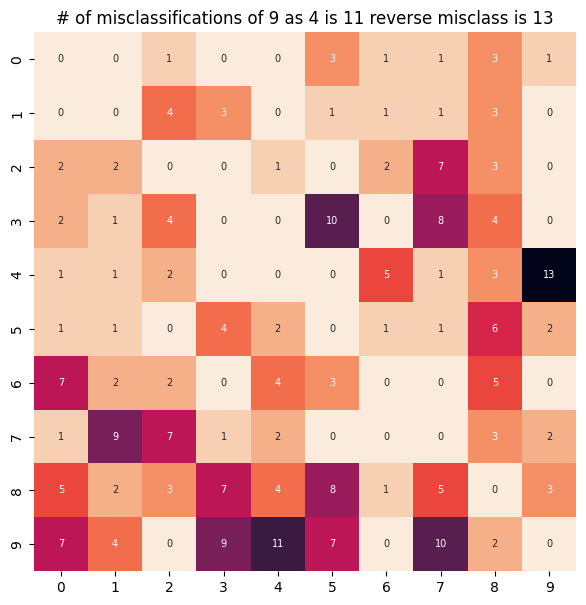

15


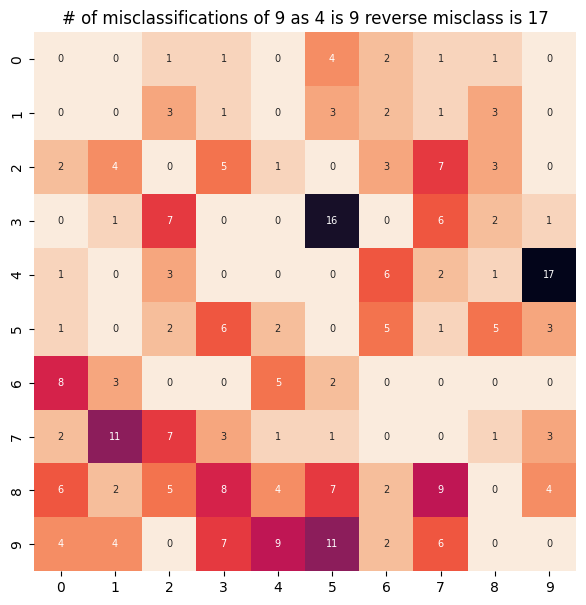

16


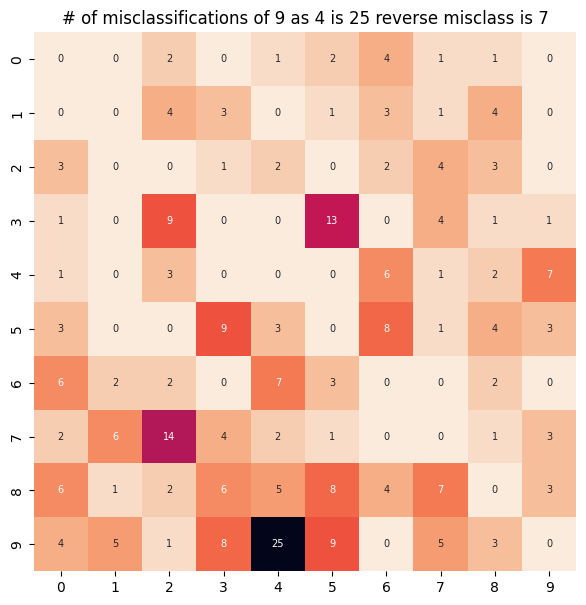

17


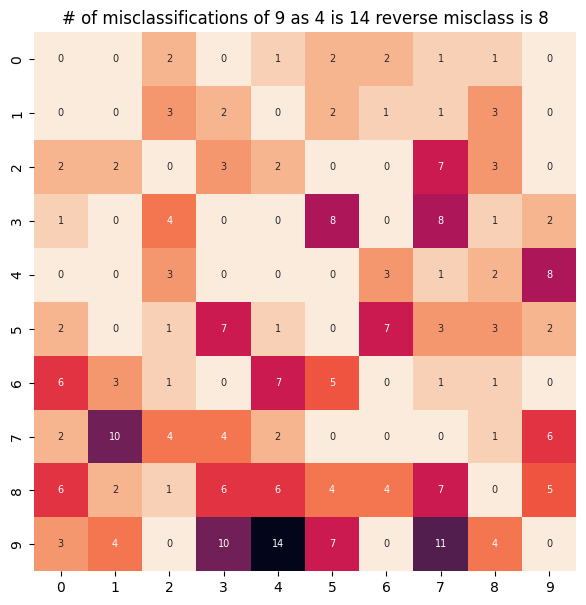

18


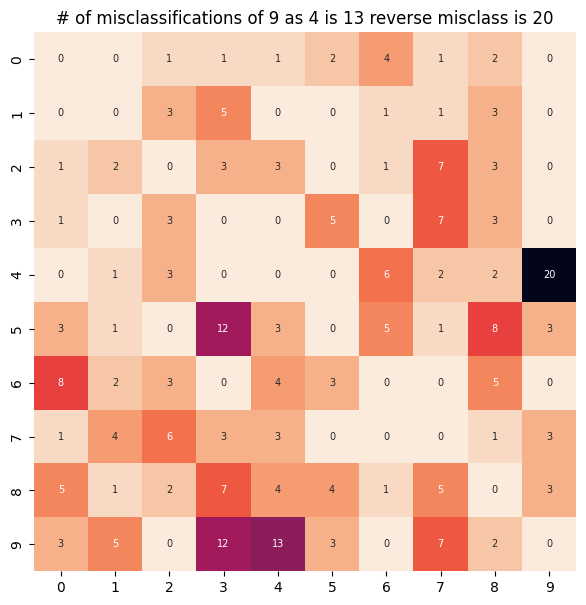

19


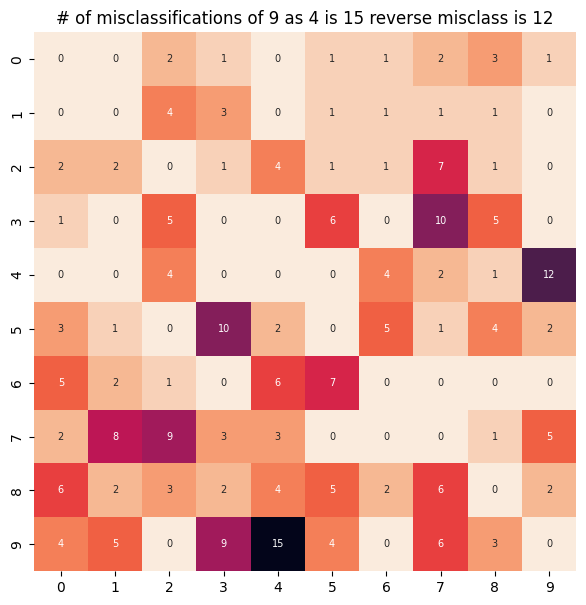

20


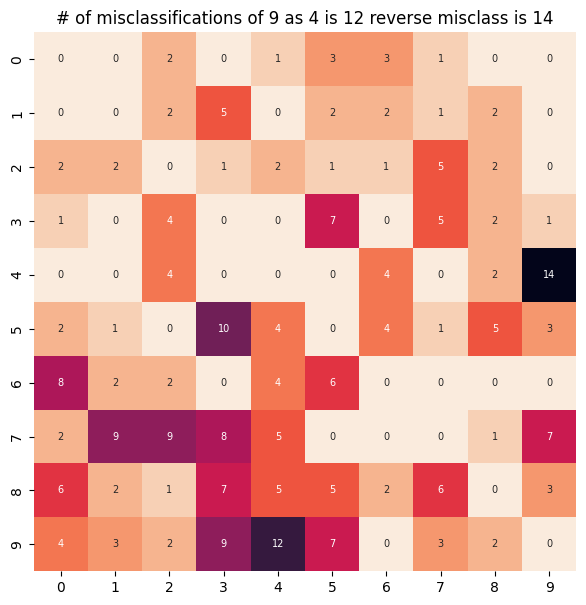

21


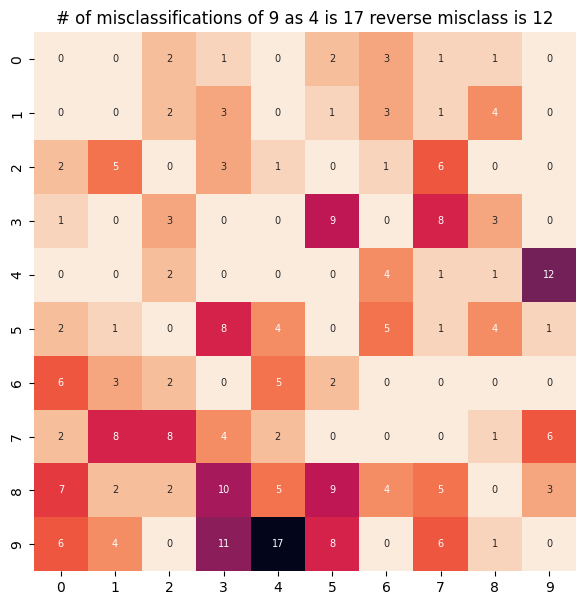

22


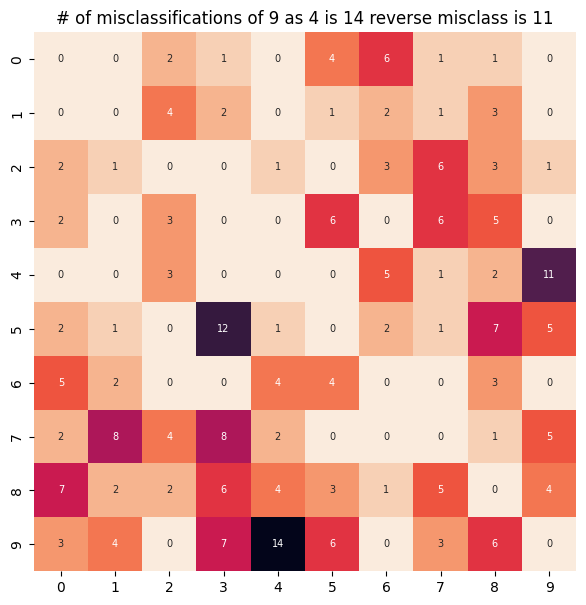

23


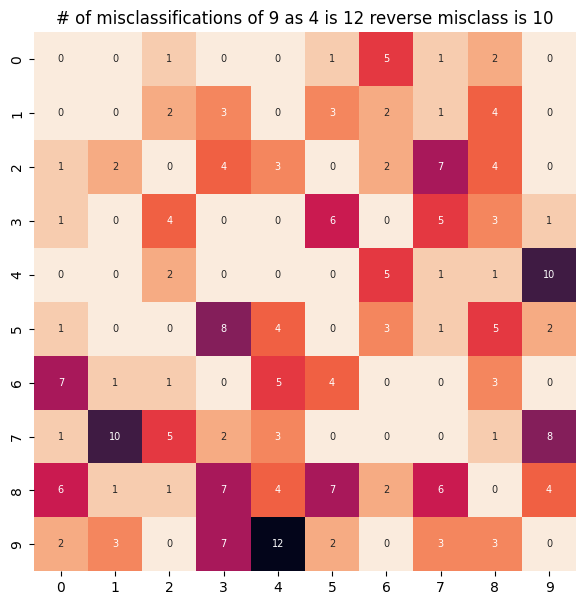

24


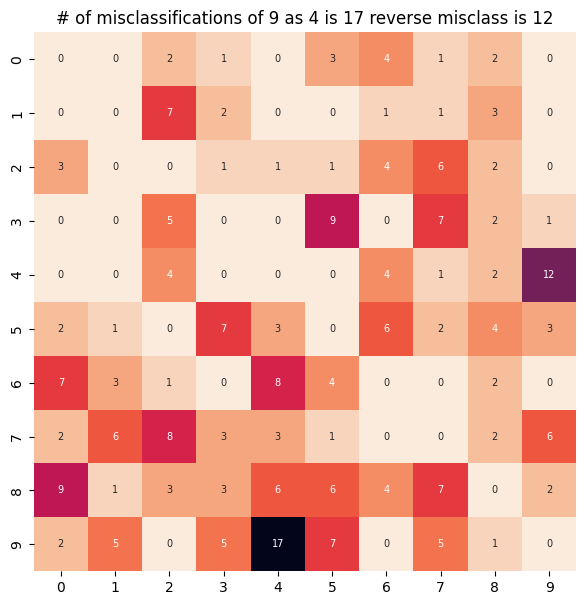

25


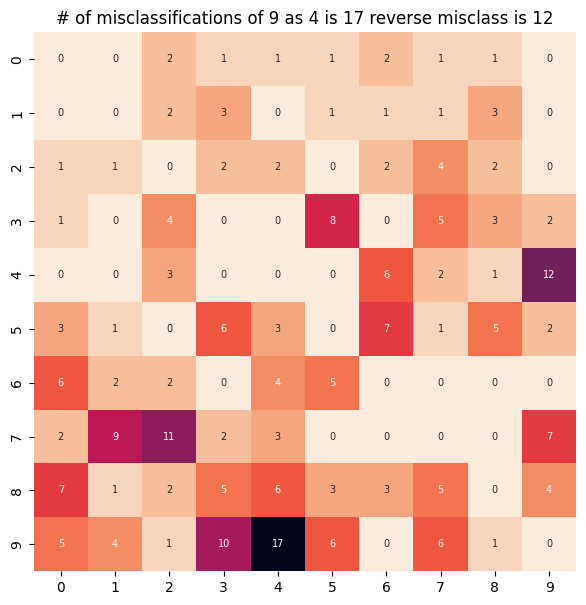

26


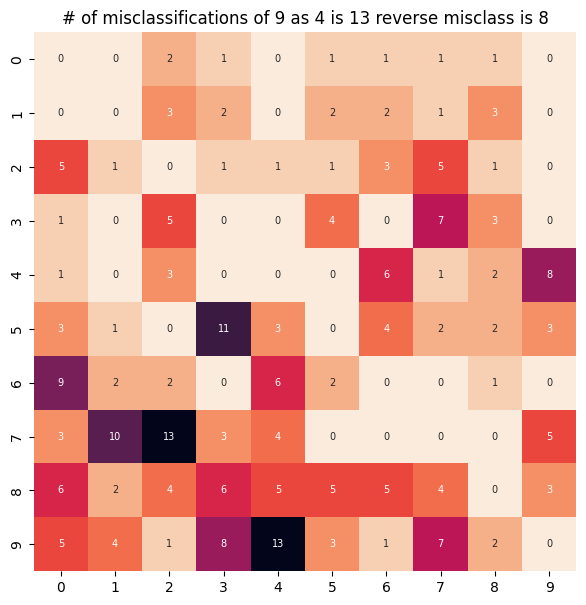

27


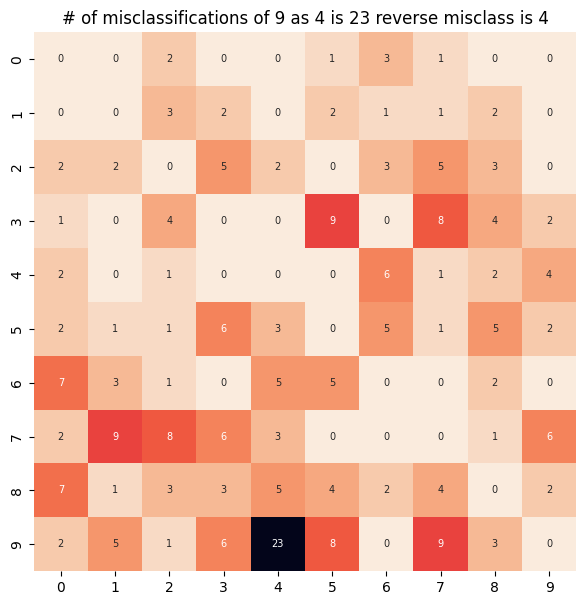

28


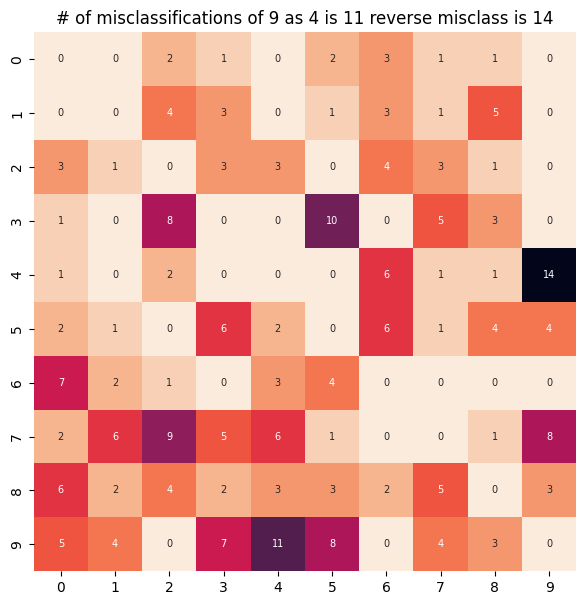

29


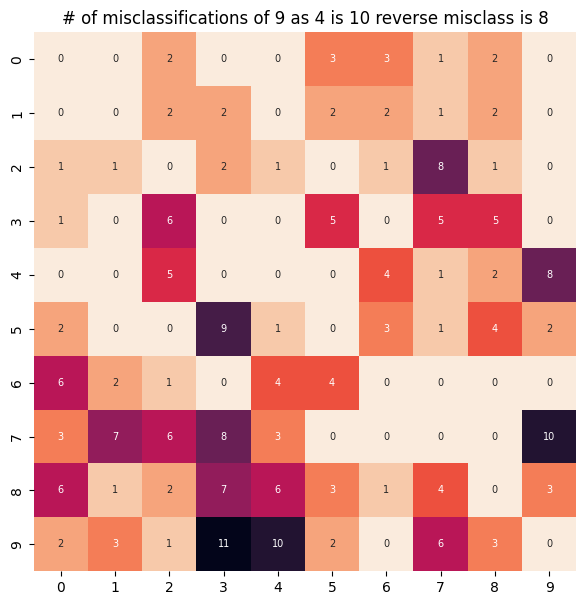

In [17]:
for i in range(len(df["model_history"])):
  print(i)
  cm = df["model_history"][i].history["cm_per_epoch"][-1].reshape((10,10))
  # cm = cm.reshape((10,10))
  

  # Create figure and axes
  fig, ax = plt.subplots(figsize=(7, 7))


  cm3_wodiag = pd.DataFrame(cm*(np.ones((10,10)) - np.eye(10)))
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.title('# of misclassifications of 9 as 4 is '+str(cm[9][4]) + ' reverse misclass is ' + str(cm[4][9])  ) 
  sns.heatmap(cm3_wodiag, annot=True, annot_kws={"size": 7},  fmt='g', cmap=sns.cm.rocket_r, cbar=False) # font size
  plt.show()




  
  

Average Misclassification Confusion Plot

[[7.08933333e+02 0.00000000e+00 1.70000000e+00 6.66666667e-01
  3.33333333e-01 1.76666667e+00 2.80000000e+00 1.03333333e+00
  1.66666667e+00 1.00000000e-01]
 [0.00000000e+00 8.36100000e+02 2.96666667e+00 2.73333333e+00
  6.66666667e-02 1.46666667e+00 1.76666667e+00 9.66666667e-01
  2.93333333e+00 0.00000000e+00]
 [2.40000000e+00 1.93333333e+00 7.65466667e+02 2.06666667e+00
  1.60000000e+00 2.33333333e-01 2.03333333e+00 5.76666667e+00
  2.43333333e+00 6.66666667e-02]
 [1.06666667e+00 1.66666667e-01 4.60000000e+00 7.30766667e+02
  3.33333333e-02 8.03333333e+00 0.00000000e+00 6.56666667e+00
  3.23333333e+00 5.33333333e-01]
 [4.33333333e-01 6.66666667e-02 2.76666667e+00 0.00000000e+00
  7.26133333e+02 0.00000000e+00 5.00000000e+00 1.13333333e+00
  1.66666667e+00 1.18000000e+01]
 [2.33333333e+00 7.66666667e-01 2.33333333e-01 8.43333333e+00
  2.43333333e+00 6.47933333e+02 4.90000000e+00 1.43333333e+00
  4.73333333e+00 2.80000000e+00]
 [7.03333333e+00 2.33333333e+00 1.73333333e+00 0.00000000e

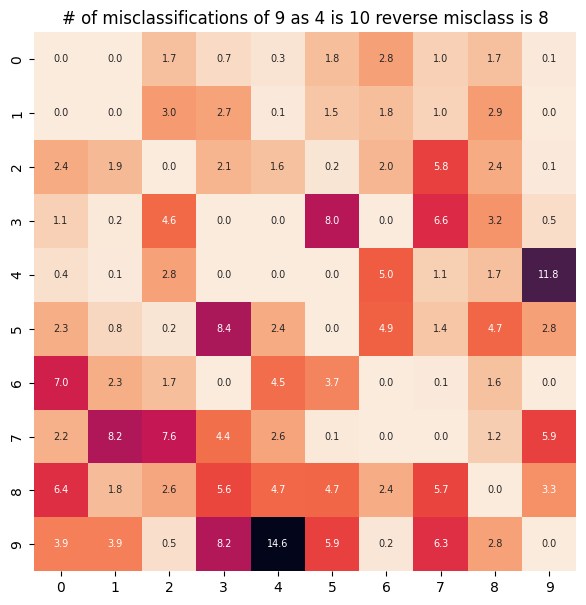

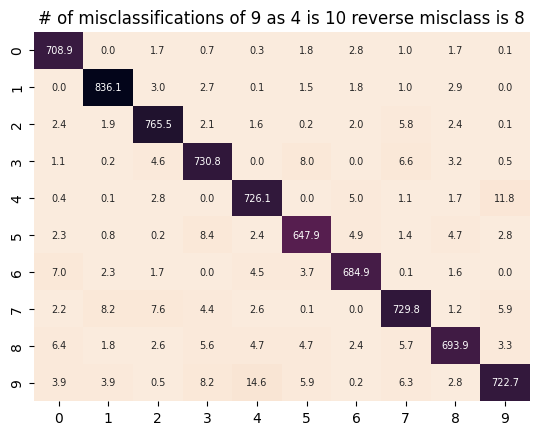

In [102]:
cm_sum = 0

for i in range(len(df["model_history"])):
  # print(i)
  cm_sum += df["model_history"][i].history["cm_per_epoch"][-1].reshape((10,10))
  # print(cm_sum)

cm_average = cm_sum/(len(df["model_history"]))
# print(cm_average)

# Create figure and axes
fig, ax = plt.subplots(figsize=(7, 7))


cm3_wodiag = pd.DataFrame(cm_average*(np.ones((10,10)) - np.eye(10)))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('# of misclassifications of 9 as 4 is '+str(cm[9][4]) + ' reverse misclass is ' + str(cm[4][9])  ) 
sns.heatmap(cm3_wodiag, annot=True, annot_kws={"size": 7},  fmt='.1f', cmap=sns.cm.rocket_r, cbar=False) # font size
plt.show()


plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('# of misclassifications of 9 as 4 is '+str(cm[9][4]) + ' reverse misclass is ' + str(cm[4][9])  ) 
sns.heatmap(pd.DataFrame(cm_average), annot=True, annot_kws={"size": 7},  fmt='.1f', cmap=sns.cm.rocket_r, cbar=False) # font size
plt.show()





Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0


ImportLibraries_DefineFunctions.py:187: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(20, 10)) # I don't think this works for some reason


Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Epochs:  110
Restored weights at  110 Patience used:  0
Total Ep

<Figure size 2000x1000 with 0 Axes>

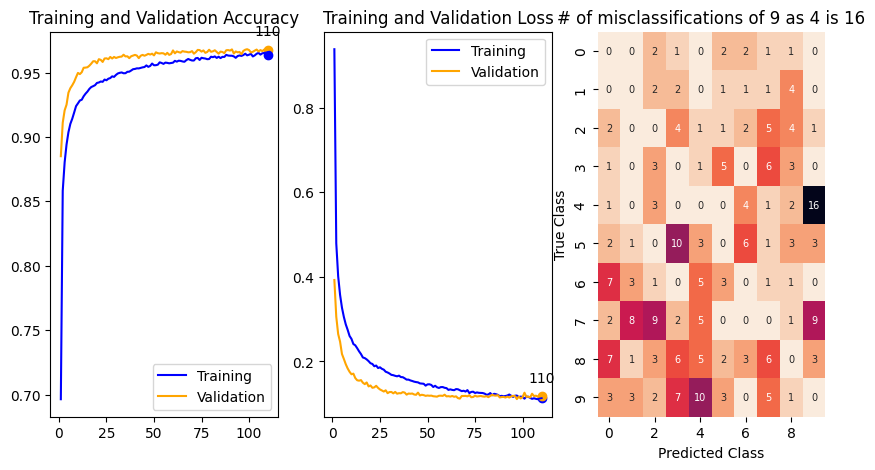

<Figure size 2000x1000 with 0 Axes>

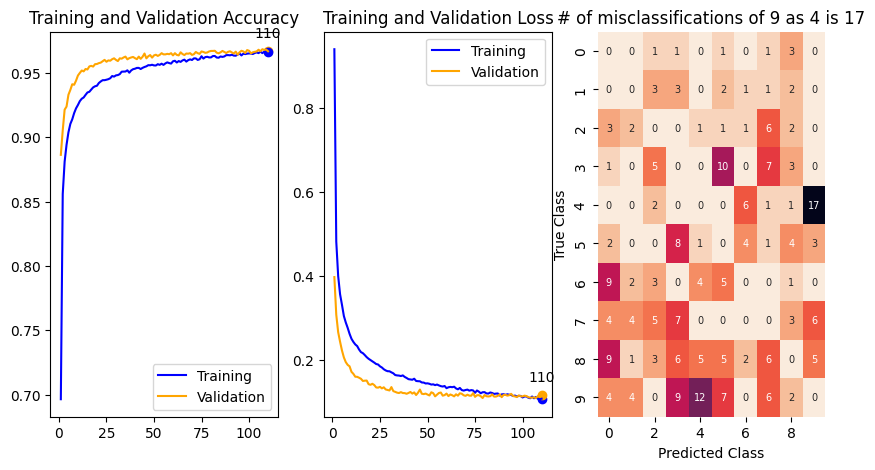

<Figure size 2000x1000 with 0 Axes>

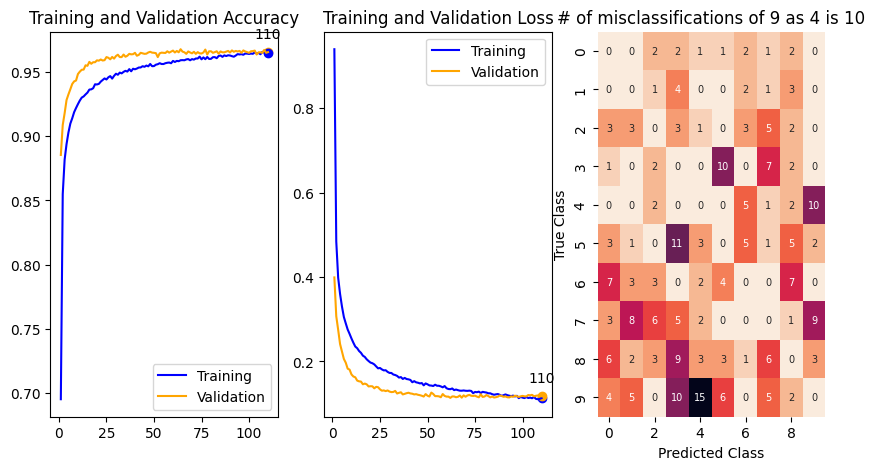

<Figure size 2000x1000 with 0 Axes>

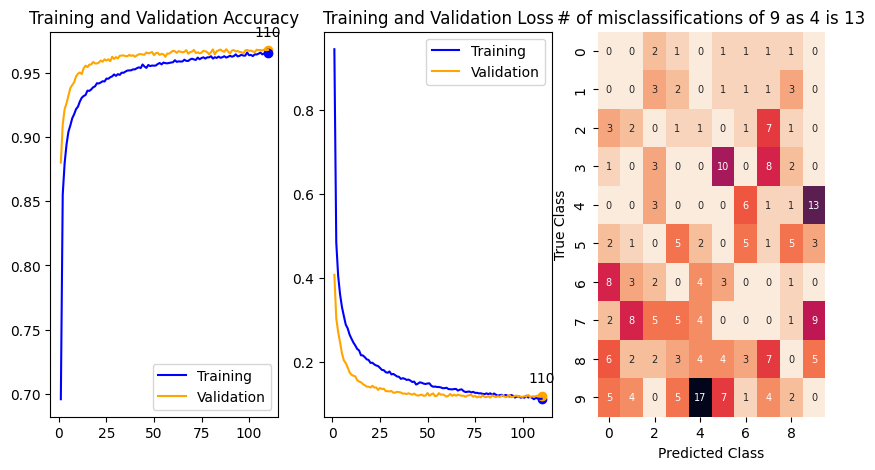

<Figure size 2000x1000 with 0 Axes>

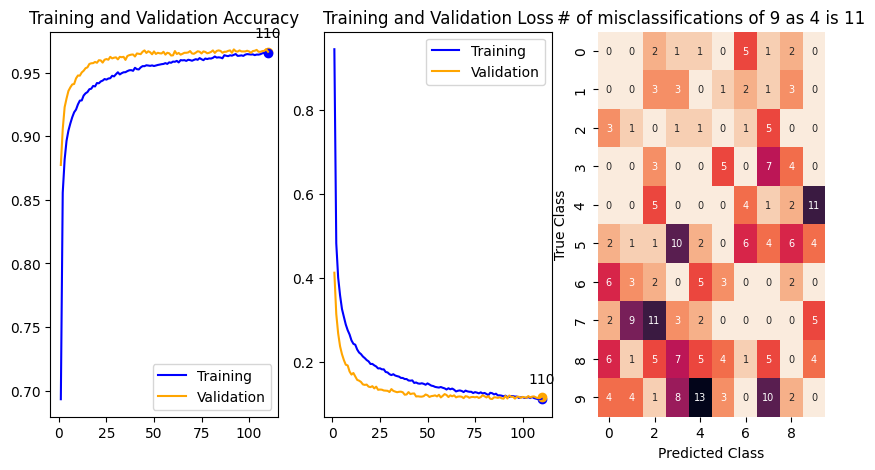

<Figure size 2000x1000 with 0 Axes>

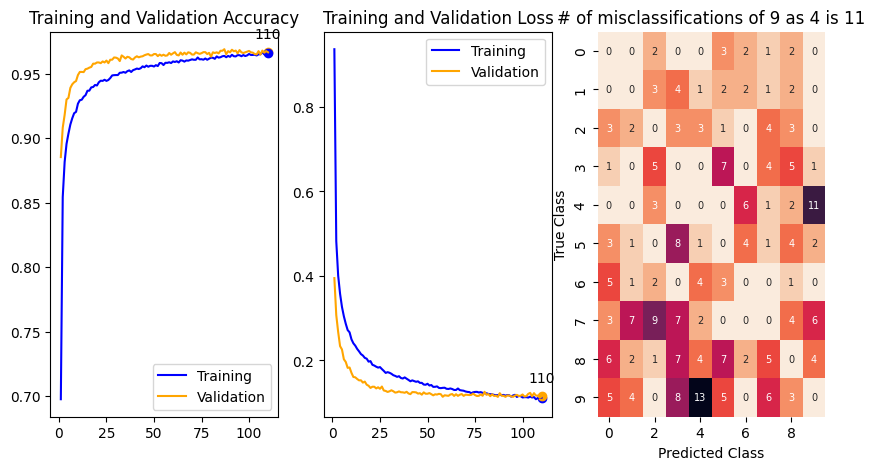

<Figure size 2000x1000 with 0 Axes>

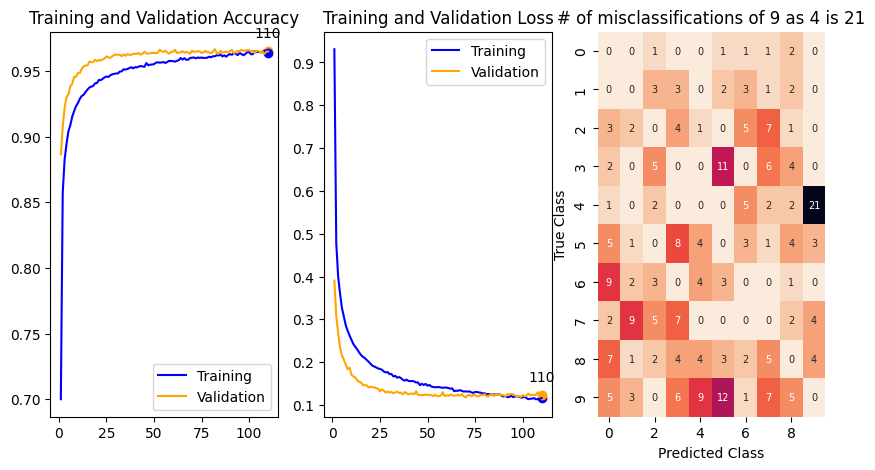

<Figure size 2000x1000 with 0 Axes>

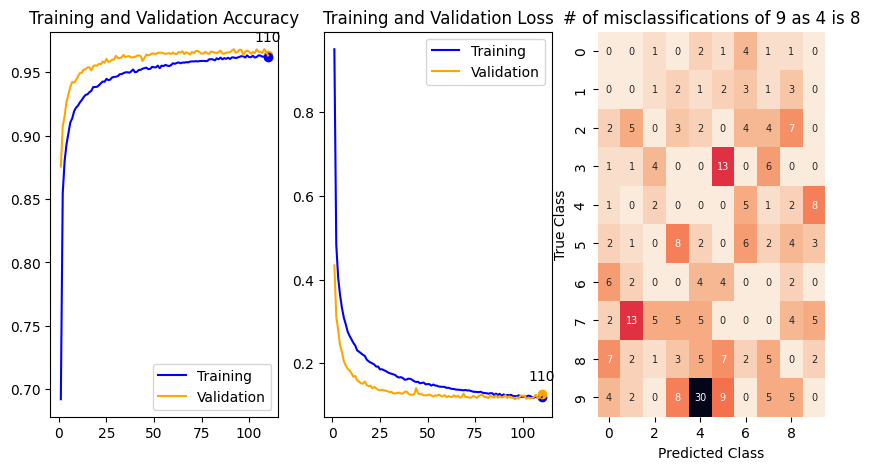

<Figure size 2000x1000 with 0 Axes>

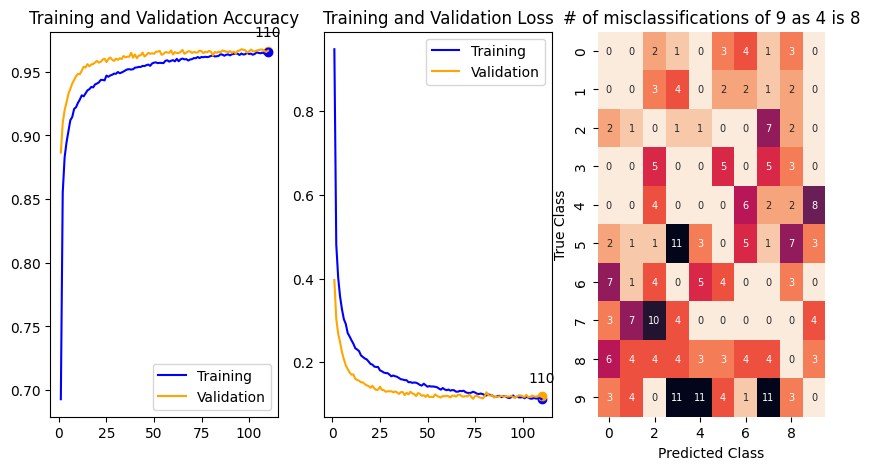

<Figure size 2000x1000 with 0 Axes>

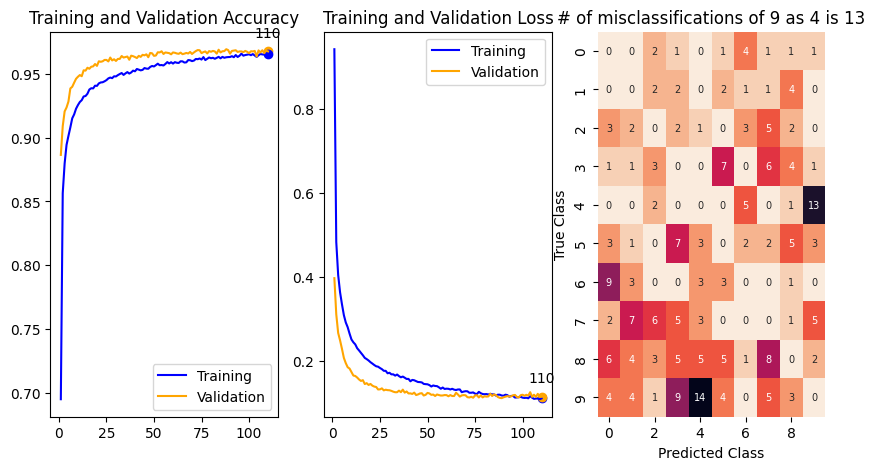

<Figure size 2000x1000 with 0 Axes>

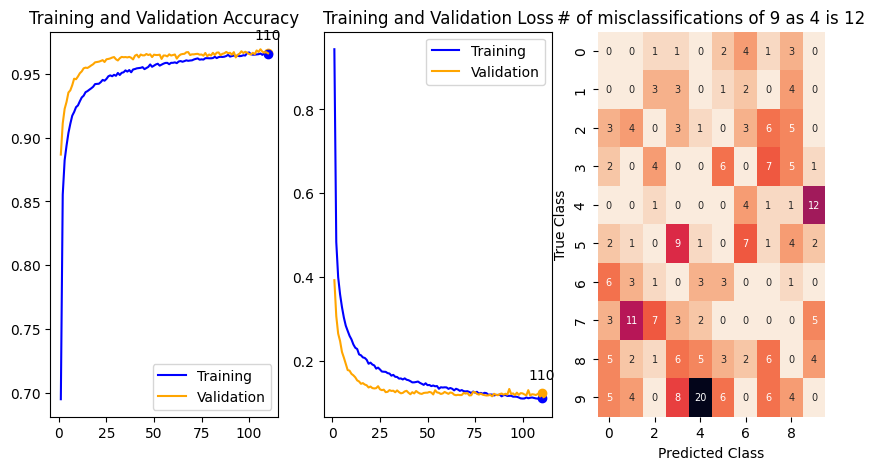

<Figure size 2000x1000 with 0 Axes>

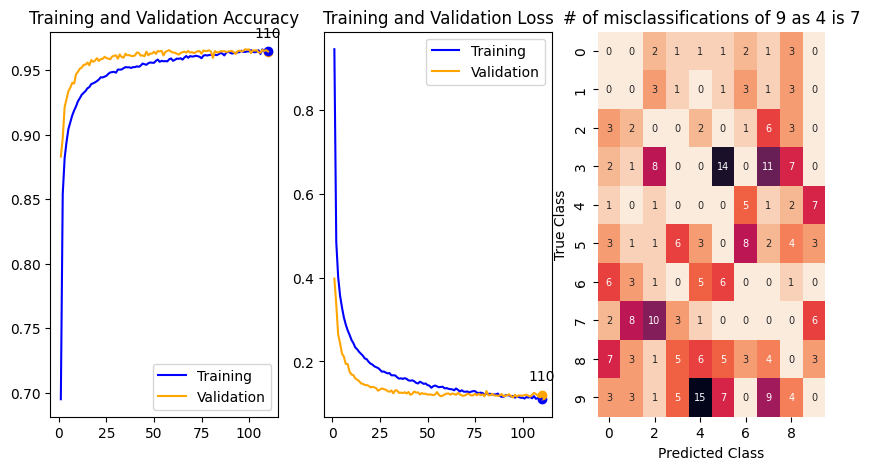

<Figure size 2000x1000 with 0 Axes>

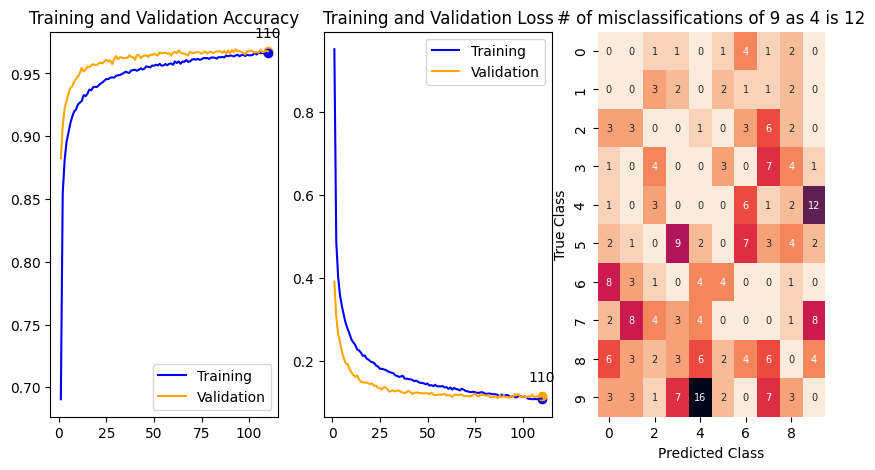

<Figure size 2000x1000 with 0 Axes>

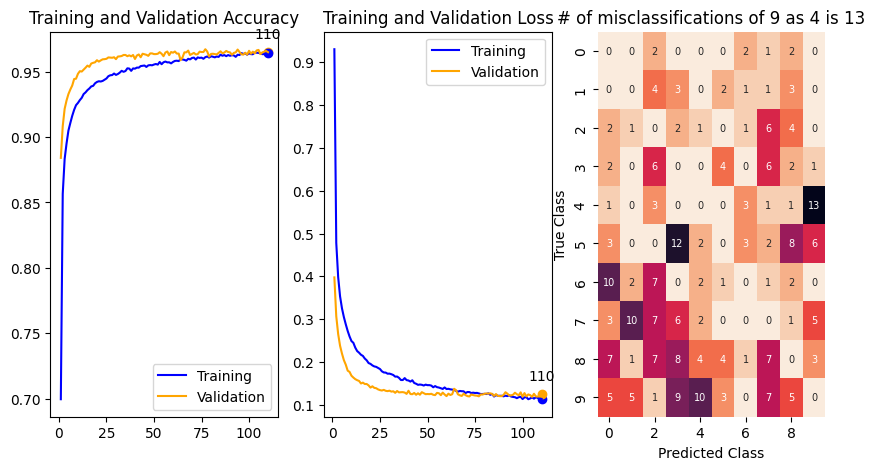

<Figure size 2000x1000 with 0 Axes>

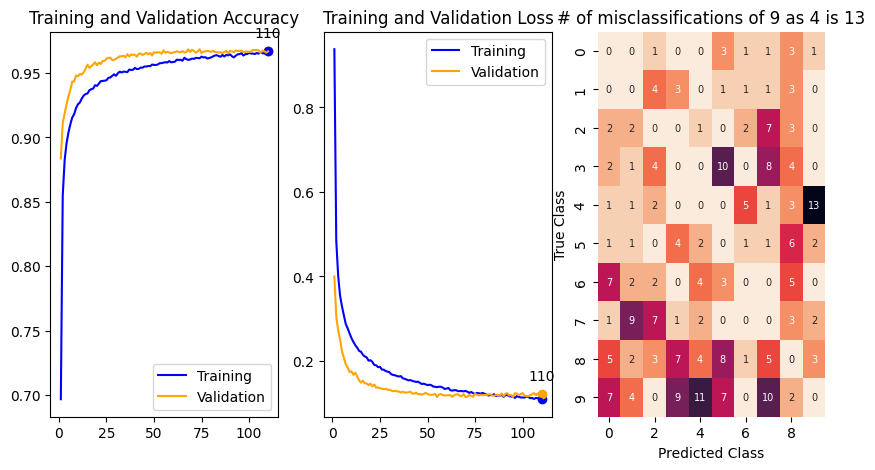

<Figure size 2000x1000 with 0 Axes>

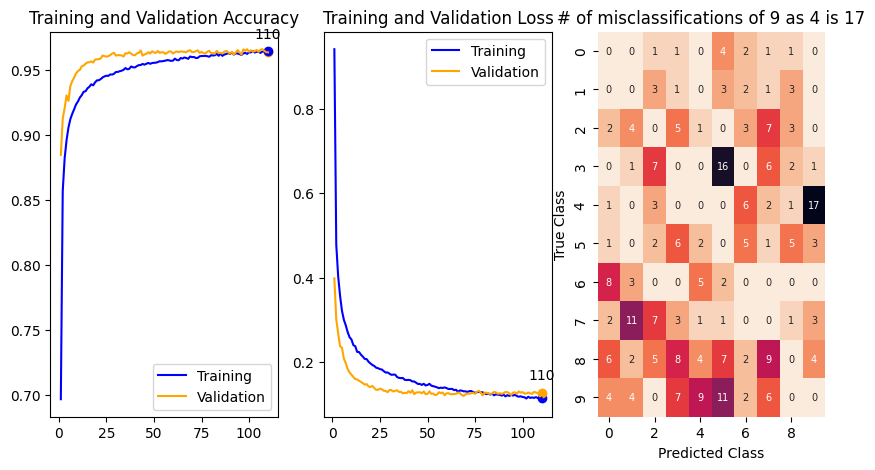

<Figure size 2000x1000 with 0 Axes>

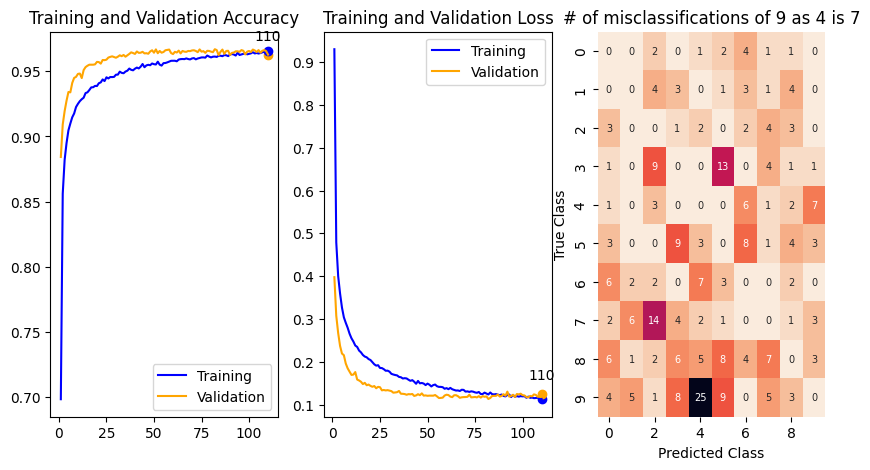

<Figure size 2000x1000 with 0 Axes>

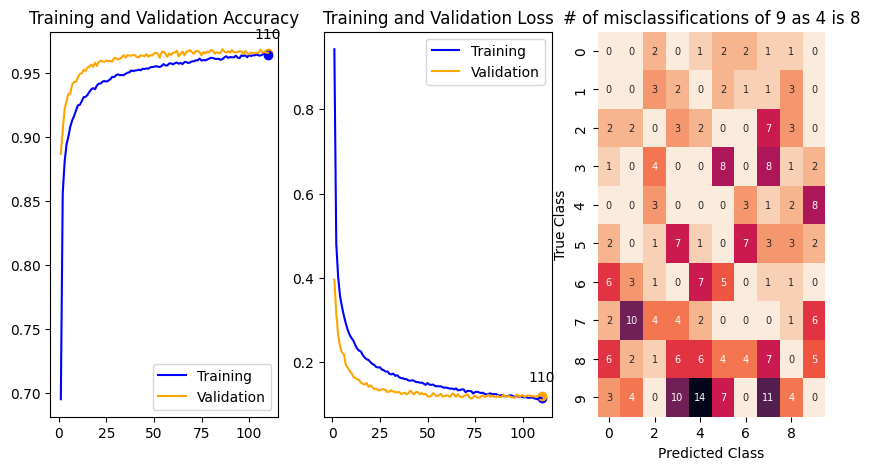

<Figure size 2000x1000 with 0 Axes>

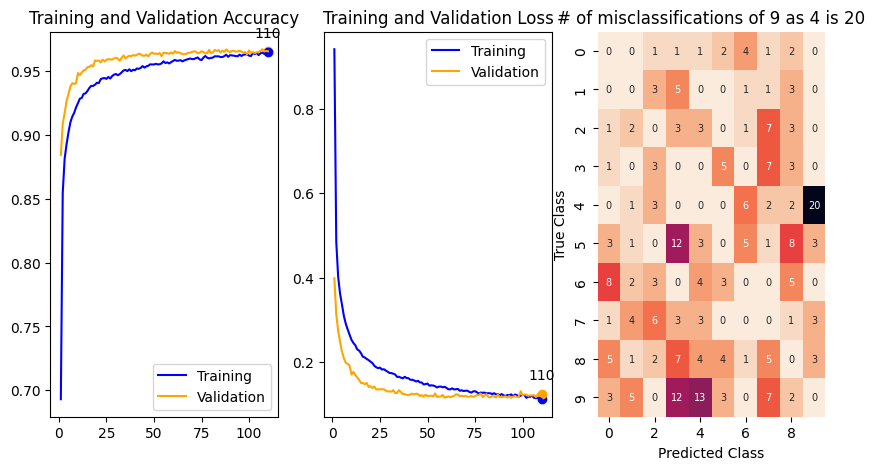

<Figure size 2000x1000 with 0 Axes>

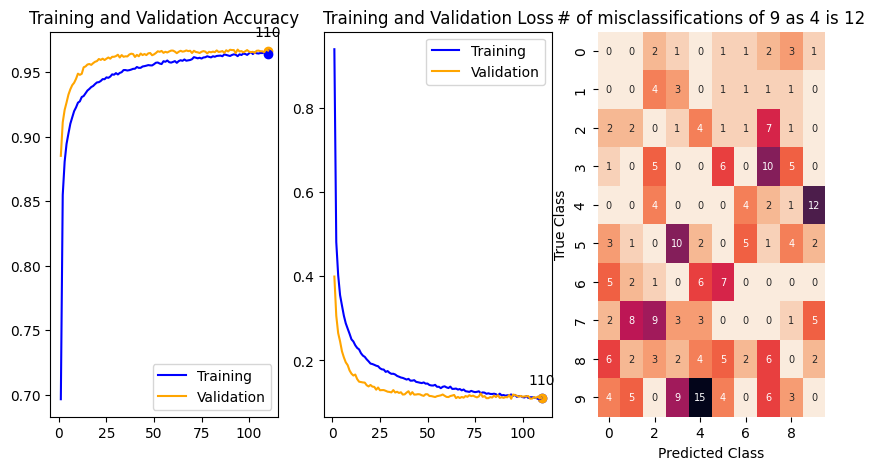

<Figure size 2000x1000 with 0 Axes>

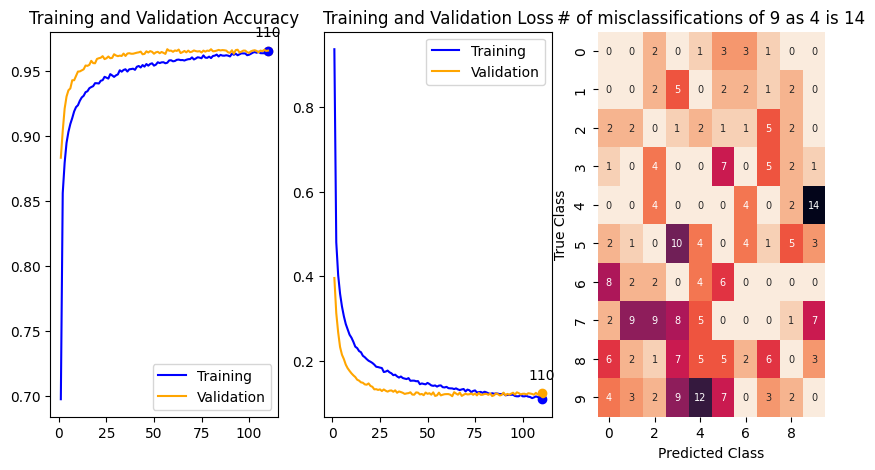

<Figure size 2000x1000 with 0 Axes>

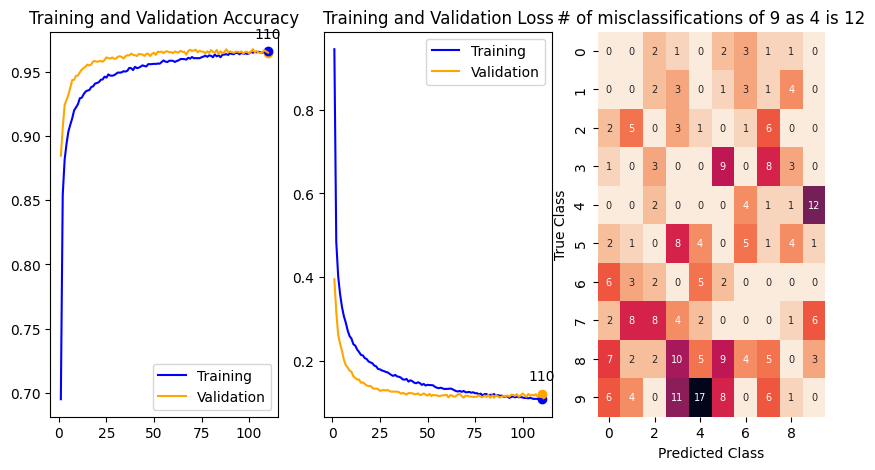

<Figure size 2000x1000 with 0 Axes>

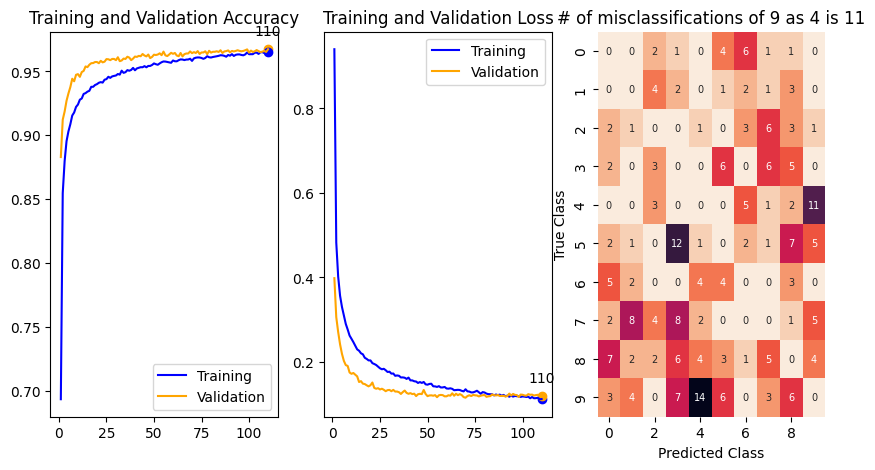

<Figure size 2000x1000 with 0 Axes>

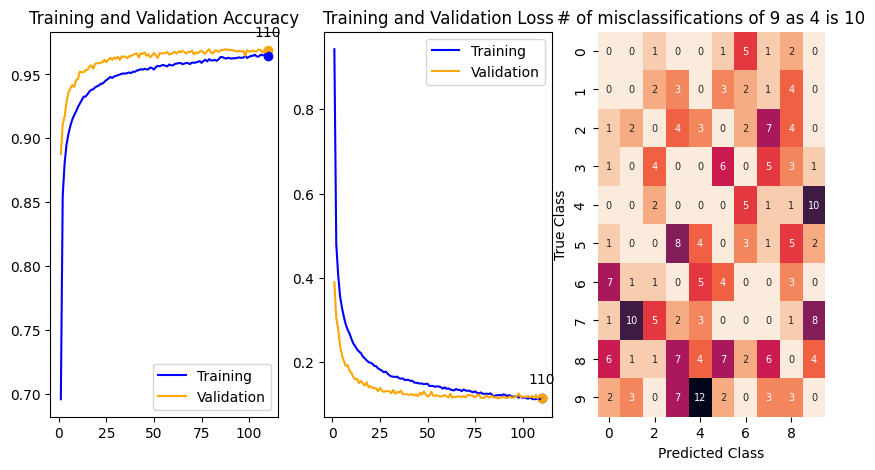

<Figure size 2000x1000 with 0 Axes>

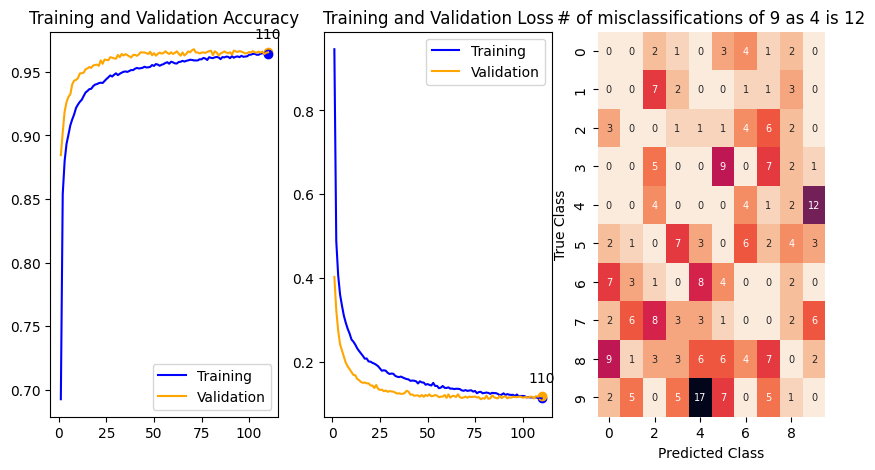

<Figure size 2000x1000 with 0 Axes>

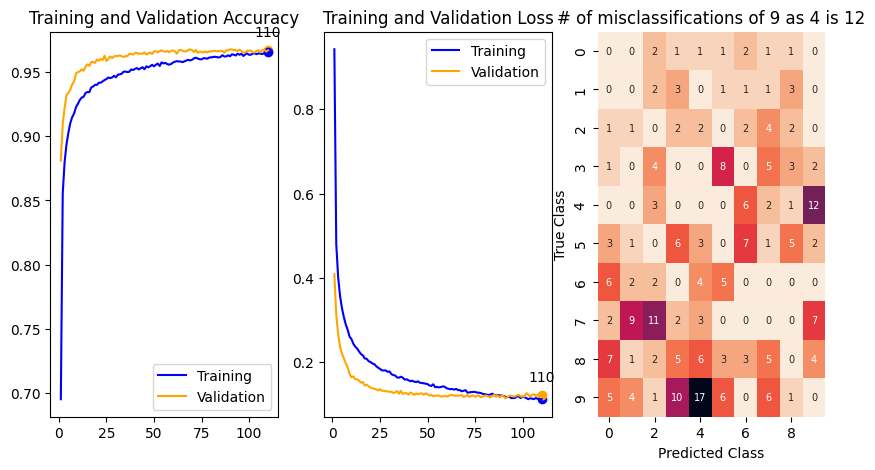

<Figure size 2000x1000 with 0 Axes>

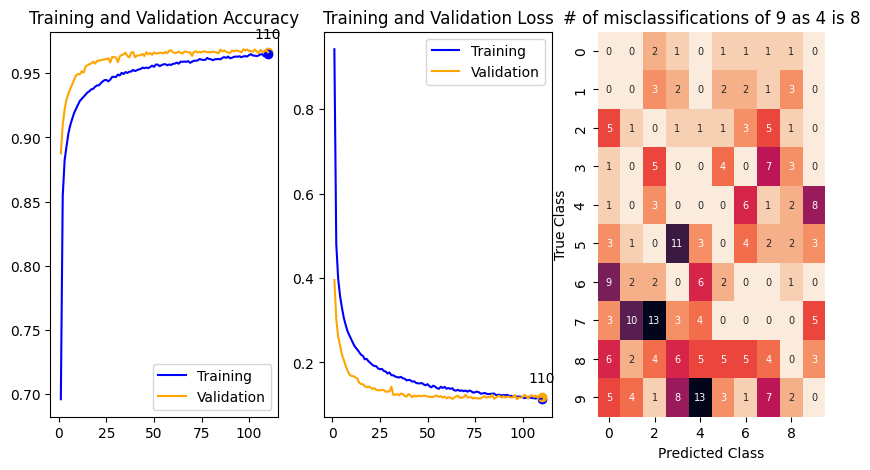

<Figure size 2000x1000 with 0 Axes>

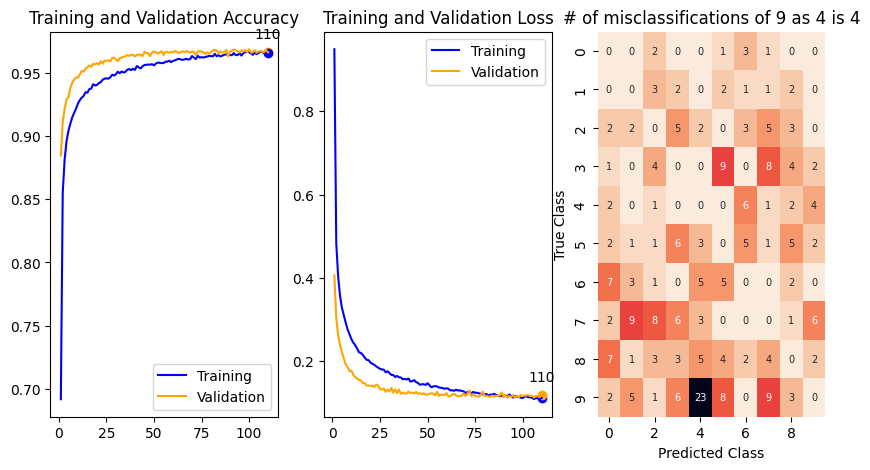

<Figure size 2000x1000 with 0 Axes>

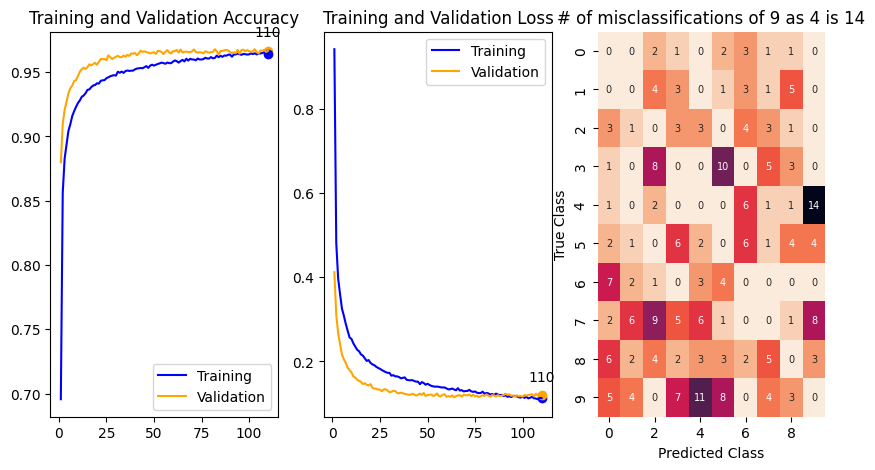

<Figure size 2000x1000 with 0 Axes>

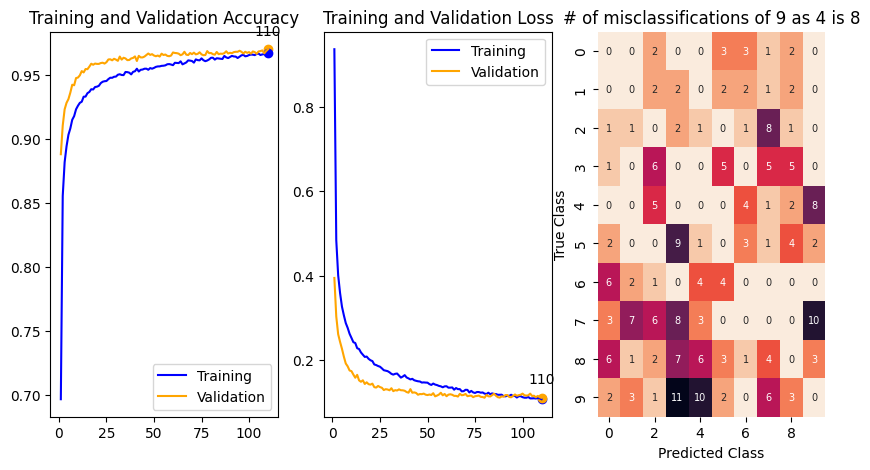

In [18]:
for i in range(len(df["model_history"])):
  plot_model_history(df["model_history"][i], 110, df["model_history"][i].history["cm_per_epoch"][-1].reshape((10,10)))

  plt.gcf().set_size_inches(10, 5)  # this works 
  # plt.gcf().suptitle(f"Lambda Value {lambda_val} for {nb_epoch} Epochs and Patience {patience} " )

  





In [40]:
df["model_history"][i].history["cm_per_epoch"][50].reshape((10,10))


#The 30th rep has 10 misclassified 9s as 4s 
df["model_history"][29].history["cm_per_epoch"][-1].reshape((10,10))[9][4]


10

Statistics

In [96]:


print("The minimum Validation Loss occurred at the following epochs for the reps")
sum_9T_4P = 0
sum_4T_9P = 0
for i in range(len(df["model_history"])):
  print(i,".", end="\t")
  print("Epoch: ", np.argmin(df["model_history"][i].history["val_loss"]), end="\t")
  print("CM_9T_4P at that epoch: ",  df["model_history"][i].history["cm_per_epoch"][np.argmin(df["model_history"][i].history["val_loss"])].reshape((10,10))[9][4]     , end="\t")
  print("CM_4T_9P at that epoch: ",  df["model_history"][i].history["cm_per_epoch"][np.argmin(df["model_history"][i].history["val_loss"])].reshape((10,10))[4][9]     )

  sum_9T_4P += df["model_history"][i].history["cm_per_epoch"][np.argmin(df["model_history"][i].history["val_loss"])].reshape((10,10))[9][4]  
  sum_4T_9P += df["model_history"][i].history["cm_per_epoch"][np.argmin(df["model_history"][i].history["val_loss"])].reshape((10,10))[4][9]  


print("The average misclassifications if Early Stopping Took place: ", sum_9T_4P/len(df["model_history"]),   "\t ", ((sum_9T_4P/len(df["model_history"]))/np.sum(cm_all, axis=2)[0][9])*100 , "percent"   )
print("The average reverse misclassifications if Early Stopping Took place: ", sum_4T_9P/len(df["model_history"]),   "\t ", ((sum_4T_9P/len(df["model_history"]))/np.sum(cm_all, axis=2)[0][4])*100 , "percent"   )


sum_94 = 0
sum_49 = 0

for j in range(len(cm_all)):
  # print(cm_all[j][9][4])
  sum_49 += cm_all[j][4][9]
  sum_94 += cm_all[j][9][4]

  # print(sum_cm)

print(" -------------- ")
print("The average misclassifications if taken out to the last training epoch: ", sum_94/len(cm_all), "\t ", (sum_94/len(cm_all)/np.sum(cm_all, axis=2)[0][9])*100 , "percent"   )
print("The average reverse misclassifications if taken out to the last training epoch: ", sum_49/len(cm_all), "\t ", (sum_49/len(cm_all)/np.sum(cm_all, axis=2)[0][4])*100 , "percent"   )

# # Val # of 9s 769.0
# #Get the original total number of 9s in the Val Set
# np.sum(cm_all, axis=2)[0][9]

# # Val # of 4s 749.0
# np.sum(cm_all, axis=2)[0][4]


The minimum Validation Loss occurred at the following epochs for the reps
0 .	Epoch:  96	CM_9T_4P at that epoch:  12	CM_4T_9P at that epoch:  15
1 .	Epoch:  106	CM_9T_4P at that epoch:  13	CM_4T_9P at that epoch:  10
2 .	Epoch:  61	CM_9T_4P at that epoch:  11	CM_4T_9P at that epoch:  13
3 .	Epoch:  82	CM_9T_4P at that epoch:  16	CM_4T_9P at that epoch:  11
4 .	Epoch:  83	CM_9T_4P at that epoch:  13	CM_4T_9P at that epoch:  12
5 .	Epoch:  108	CM_9T_4P at that epoch:  15	CM_4T_9P at that epoch:  10
6 .	Epoch:  69	CM_9T_4P at that epoch:  12	CM_4T_9P at that epoch:  10
7 .	Epoch:  95	CM_9T_4P at that epoch:  15	CM_4T_9P at that epoch:  11
8 .	Epoch:  73	CM_9T_4P at that epoch:  11	CM_4T_9P at that epoch:  11
9 .	Epoch:  88	CM_9T_4P at that epoch:  10	CM_4T_9P at that epoch:  19
10 .	Epoch:  83	CM_9T_4P at that epoch:  21	CM_4T_9P at that epoch:  8
11 .	Epoch:  108	CM_9T_4P at that epoch:  12	CM_4T_9P at that epoch:  10
12 .	Epoch:  86	CM_9T_4P at that epoch:  13	CM_4T_9P at that epoch:  8